In [1]:
from __future__ import division
import gym
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

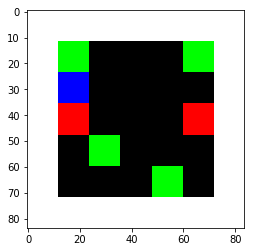

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False, size=5)

This is the game we'll be working on. The player can move the blue square up, down, left or right. The point of the game is to get to the green square (+1 reward) and avoid the red square (-1 reward). Blocks are randomized

Original shape: (84, 84, 3)
Processed shape: (84, 84, 3)


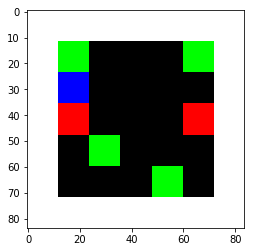

In [3]:
def process_state(state):
    """ This processes the state and converts to black & white. This will help speed up learning
        as the number of parameters will be reduced.
    """
    return state
#     Here you can add other state manipulations like dilation and convering state to b&w
#     r, g, b = state[:,:,0], state[:,:,1], state[:,:,2]
#     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

#     return gray

plt.imshow(process_state(env.state))
print("Original shape: {}".format(env.state.shape))
print("Processed shape: {}".format(process_state(env.state).shape))

## Implementing the network

In [4]:
class Qnetwork():
    def __init__(self, final_layer_size):
        
        # A placeholder use to hold the a group of images (84x84x3) in this case
        self.im_input = tf.placeholder(shape=[None,*process_state(env.state).shape], dtype=tf.float32)
                
        # There will be four layers of convolutions performed on the image input
        # A convolution take a portion of an input and matrix multiplies
        # a filter on the portion to get a new input (see below)
        self.conv1 = slim.conv2d(
            inputs = self.im_input, num_outputs=32, kernel_size=[8,8], 
            stride=[4,4], padding="VALID"
        )

        self.conv2 = slim.conv2d(
            inputs = self.conv1, num_outputs=64, kernel_size=[4,4], 
            stride=[2,2], padding="VALID"
        )
        
        self.conv3 = slim.conv2d(
            inputs = self.conv2, num_outputs=64, kernel_size=[3,3], 
            stride=[1,1], padding="VALID"
        )

        self.conv4 = slim.conv2d(
            inputs = self.conv3, num_outputs=final_layer_size, kernel_size=[7,7], 
            stride=[1,1], padding="VALID"
        )
        
        # We then separate the final convolution layer into an advantage and value
        # stream. The value function is how well off you are in a given state.
        # The advantage is the how much better off you are after making a particular
        # move. Q is the value function of a state after a given action.
        # Advantage(state, action) = Q(state, action) - Value(state)
        self.stream_AC, self.stream_VC = tf.split(
            value=self.conv4,num_or_size_splits=2,axis=len(process_state(env.state).shape))
        
        # We then flatten the advantage and value functions
        self.stream_AC = slim.flatten(self.stream_AC)
        self.stream_VC = slim.flatten(self.stream_VC)
        
        # We define weights for our advantage and value layers. We will train these
        # layers so the matmul will match the expected value and advantage from play
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([final_layer_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([final_layer_size//2,1]))
        self.Advantage = tf.matmul(self.stream_AC, self.AW)
        self.Value = tf.matmul(self.stream_VC, self.VW)
        
        # To get the Q output, we need to add the value to the advantage.
        # The advantage to be evaluated will bebased on how good the action
        # is based on the average advantage of that state
        self.Q_out = self.Value + tf.subtract(self.Advantage,
                                              tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))

        # Our prediction is then the highest Q output. It represents the best
        # move we can make as it is expected to return the highest Q value
        self.predict = tf.argmax(self.Q_out, 1)
        
        # We need to keep track of our losses (sum of square differences)
        self.target_Q = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions,dtype=tf.float32)
        
        # Final Q values that we want to learn from
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), axis=1)
        
        # Calculating errors and training
        self.td_error = tf.square(self.target_Q - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_model = self.trainer.minimize(self.loss)

## How convolutions work
![How convolutions work](img/convolutions.gif)

## Experience Replay

This class allows us to store experiences and sample them randomly for learning

In [5]:
def update_target_graph(tf_vars, tau):
    """ 
    This function creates tensors that update the target graph 
    with values from main graph. The first half of tf_vars (trainables)
    are from the main graph and the second half is from the target graph.
    The operations created update the value of the target graph to 
    a weighted average of the original values and main values.
    
    E.g.
        tf_vars = [0,1,2,3,4,5]
        tau = 0.1
        main_graph = [0,1,2]
        target_graph = [3,4,5]
        
        after ops run:
        target_graph =
            [((0 * 0.1) + (3 * 0.9)),
             ((1 * 0.1) + (4 * 0.9)),
             ((2 * 0.1) + (5 * 0.9))] == [2.7, 3.7, 4.7]
    """
    num_vars = len(tf_vars)
    mid_idx = num_vars // 2
    op_holder = []
    for idx, var in enumerate(tf_vars[:mid_idx]):
        updated_var = tf_vars[mid_idx + idx]
        updated_var = updated_var.assign(
            (var.value() * tau) + ((1-tau) * tf_vars[mid_idx + idx].value()))
        op_holder.append(updated_var)
    return op_holder

def update_target(op_holder, sess):
    """ Runs the operations in the list of operations"""
    for op in op_holder:
        sess.run(op)

In [6]:
class ExperienceReplay:
    def __init__(self,buffer_size=50000):
        """ Data structure used to hold game experiences """
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        
    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer),size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output,(size,-1))
        return sample_output

## Training the network

In [7]:
batch_size = 64 # How many experiences to use for each training step
num_epochs = 10 # How many epochs to train
update_freq = 1 # How often you update the network
y = 0.99 # Discount factor
prob_random_start = 1. # Starting chance of random action
prob_random_end = 0.1 # Ending chance of random action
annealing_steps = 10000. # Steps of training to reduce from start_e -> end_e
num_episodes = 10000 # How many episodes of game environment to train
pre_train_episodes = 100 # Number of episodes of random actions
max_num_step = 50 # Maximum allowed episode length
load_model = True # Whether to load a saved model
path = "./dqn" # Path to save our model to
final_layer_size = 512 # Size of the final convolution layer before 
                       # splitting into Advantage and Value streams
tau = 0.001 # Rate to update target network toward primary network

In [ ]:
# Reset everything
tf.reset_default_graph()

# Setup our Q-networks
main_qn = Qnetwork(final_layer_size)
target_qn = Qnetwork(final_layer_size)

# Saver to save our neural network
saver = tf.train.Saver()

# Variables we'll be training in the neural network
trainables = tf.trainable_variables()

# Returns our variables
target_ops = update_target_graph(trainables, tau)

# Setup our experience replay to store and learn from episodes
experience_replay = ExperienceReplay()

# We'll begin by acting complete randomly. As we gain experience and improve,
# we will begin reducing the probability of acting randomly, and instead
# take the actions that our Q network suggests
prob_random = tf.get_variable("prob_random",initializer=prob_random_start,trainable=False, dtype=tf.float32)
prob_random_drop = (prob_random_start - prob_random_end) / annealing_steps

num_steps = [] # Tracks number of steps per episode
rewards = [] # Tracks rewards per episode
total_steps = 0 # Tracks cumulative steps taken in training

print_every = 100 # How often to print status
save_every = 50 # How often to save

# Variable to keep track of episode
num_episode = tf.get_variable("num_episode", initializer=0, trainable=False, dtype=tf.int32)

# Initializer
init = tf.global_variables_initializer()

# Setup path for saving
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init) # initialize all variables
    if load_model == True:
        # Load the model from the last checkpoint
        ckpt = tf.train.get_checkpoint_state(path)
        if ckpt is not None:
            print("Loading model...")
            saver.restore(sess, ckpt.model_checkpoint_path)
    
    num_episode_val = num_episode.eval(sess)
    
    while num_episode_val < num_episodes:
        
        # Create an experience replay for the current episode
        episode_buffer = ExperienceReplay()
        
        # Get the game state from the environment
        state = env.reset()
        state = process_state(state)
        
        done = False # Game is complete
        sum_rewards = 0 # Running sum of rewards in episode
        cur_step = 0 # Running sum of number of steps taken in episode
        
        while cur_step < max_num_step and not done:
            cur_step += 1
            total_steps += 1
            
            if np.random.rand() < prob_random.eval(sess) or \
                num_episode_val < pre_train_episodes:
                    # Act randomly based on prob_random or if we
                    # have not accumulated enough pre_train episodes
                    action = np.random.randint(env.actions)
            else:
                # Decide what action to take from the Q network
                feed_dict = {main_qn.im_input: [state]}
                action = sess.run(main_qn.predict,
                                  feed_dict=feed_dict)
                action = action[0]
            
            # Take the action and retrieve the next state, reward and done
            next_state, reward, done = env.step(action)
            next_state = process_state(next_state)
  
            # Setup the episode to be stored in the episode buffer
            episode = np.array([[state],action,reward,[next_state],done])
            episode = episode.reshape(1,-1)
            
            # Store the experience in the episode buffer
            episode_buffer.add(episode)
            
            # Update the running rewards
            sum_rewards += reward
            
            # Update the state
            state = next_state

        if num_episode_val > pre_train_episodes:
            # Training the network

            if prob_random.eval(sess) > prob_random_end:
                # Drop the probability of a random action
                sess.run(prob_random.assign_sub(prob_random_drop))

            if num_episode_val % update_freq == 0:
                for num_epoch in range(num_epochs):
                    # Train batch is [[state,action,reward,next_state,done],...]
                    train_batch = experience_replay.sample(batch_size)

                    # Separate the batch into its components
                    train_state, train_action, train_reward, \
                        train_next_state, train_done = train_batch.T

                    # Stack the train_state and train_next_state for learning
                    train_state = np.vstack(train_state)
                    train_next_state = np.vstack(train_next_state)

                    # Our predictions (actions to take) from the main Q network
                    train_next_state_action = sess.run(
                        main_qn.predict,
                        feed_dict = { 
                          main_qn.im_input: train_state
                        })

                    # The Q values from our target network from the next state
                    train_next_state = sess.run(
                        target_qn.Q_out,
                        feed_dict = {
                         target_qn.im_input: train_next_state})

                    # Tells us whether game over or not
                    # We will multiply our gradients by this value
                    # to ensure we don't train on the last move
                    train_gameover = train_done == 0

                    # Q value of the next state based on action
                    train_next_state_values = train_next_state[range(batch_size), train_next_state_action]

                    # Reward from the action chosen in the train batch
                    target_q = train_reward + (y * train_next_state_values * train_gameover)

                    # Train the main model
                    _ = sess.run(main_qn.update_model, \
                                feed_dict={
                                    main_qn.im_input: train_state,
                                    main_qn.target_Q: target_q,
                                    main_qn.actions: train_action
                                })

                    # Update the target model with values from the main model
                    update_target(target_ops, sess)
                    
        # Increment the episode
        sess.run(num_episode.assign_add(1))
        num_episode_val = num_episode.eval(sess)
        
        experience_replay.add(episode_buffer.buffer)
        num_steps.append(cur_step)
        rewards.append(sum_rewards)
        
        if num_episode_val % save_every == 0:
            # Save the model
            saver.save(sess, 
                       path + "/model",
                       global_step=num_episode.eval(sess))
        if num_episode_val % print_every == 0:
            # Print progress
            print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}".format(
                num_episode_val, np.mean(rewards[-print_every:]), prob_random.eval(sess)))

Num episode: 100 Mean reward: 2.1300 Prob random: 1.0000
Num episode: 200 Mean reward: 1.9800 Prob random: 0.9911
Num episode: 300 Mean reward: 1.9000 Prob random: 0.9821
Num episode: 400 Mean reward: 2.4800 Prob random: 0.9731
Num episode: 500 Mean reward: 2.5600 Prob random: 0.9641
Num episode: 600 Mean reward: 2.5100 Prob random: 0.9551
Num episode: 700 Mean reward: 2.6100 Prob random: 0.9461
Num episode: 800 Mean reward: 2.8400 Prob random: 0.9371
Num episode: 900 Mean reward: 3.4800 Prob random: 0.9281
Num episode: 1000 Mean reward: 3.2900 Prob random: 0.9191
Num episode: 1100 Mean reward: 3.4000 Prob random: 0.9101
Num episode: 1200 Mean reward: 3.2000 Prob random: 0.9011
Num episode: 1300 Mean reward: 4.1700 Prob random: 0.8921
Num episode: 1400 Mean reward: 3.5800 Prob random: 0.8831
Num episode: 1500 Mean reward: 3.6400 Prob random: 0.8741
Num episode: 1600 Mean reward: 4.2700 Prob random: 0.8651
Num episode: 1700 Mean reward: 3.9500 Prob random: 0.8561
Num episode: 1800 Mean 

Loading model...
INFO:tensorflow:Restoring parameters from ./dqn/model-8900


[2017-10-25 18:23:26,795] Restoring parameters from ./dqn/model-8900


Total rewards: 13.0


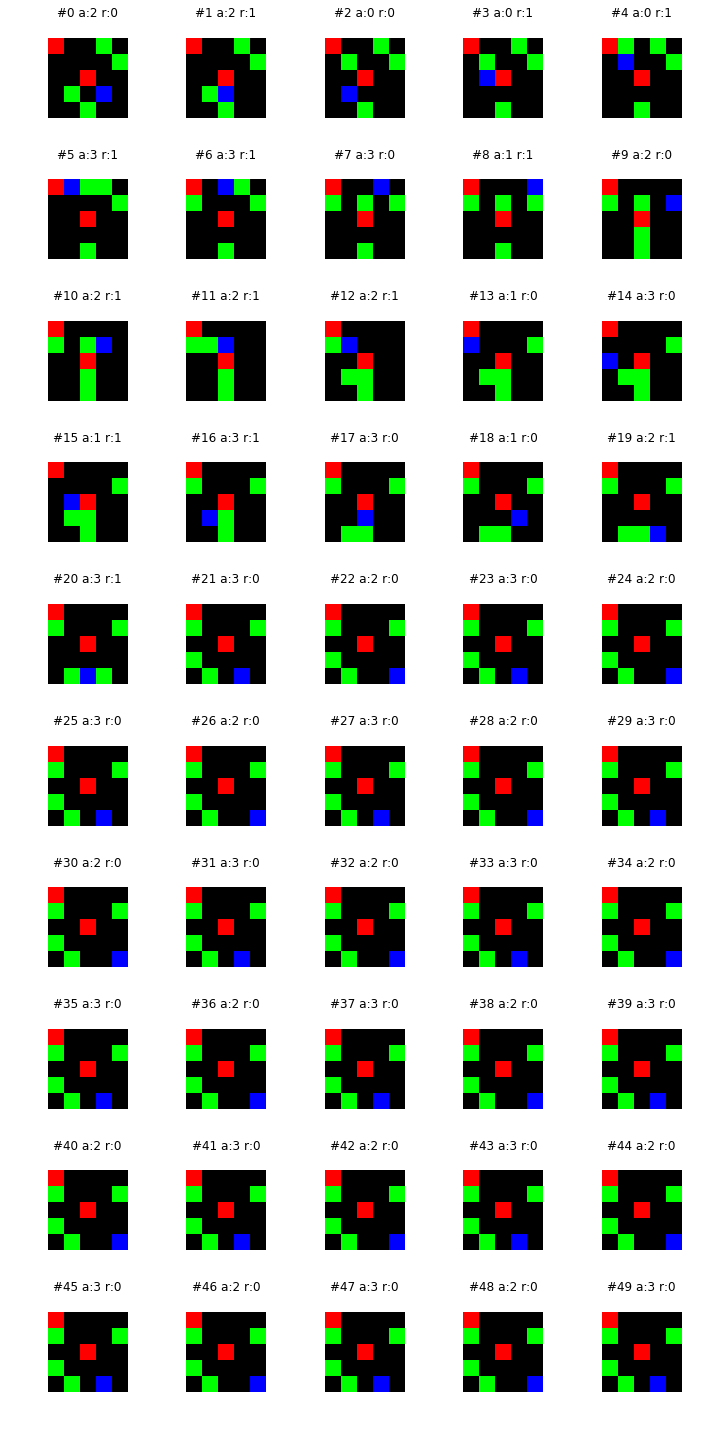

In [11]:
f, axes = plt.subplots(nrows=max_num_step//5, ncols=5, 
                       sharex=True,sharey=True, figsize=(10,20))

with tf.Session() as sess:
    sess.run(init)
    print("Loading model...")
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
    done = False
    num_step = 0
    sum_rewards = 0
    state = env.reset()
    state = process_state(state)
    
    while not done and num_step < max_num_step:        
        action = sess.run(main_qn.predict, feed_dict = {
            main_qn.im_input: [state]})[0]
        next_state, reward, done = env.step(action)
        next_state = process_state(next_state)
        sum_rewards += reward
        ax = axes.ravel()[num_step]
        ax.imshow(state)
        ax.set_axis_off()
        ax.set_title("#{} a:{} r:{}".format(num_step,action,int(reward)))
        state = next_state
        num_step += 1
        
print("Total rewards: {}".format(sum_rewards))
f.tight_layout()